# Import packages

In [101]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

In [102]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# Case 4: Hospital_accessibility
task_name ='Hospital_accessibility'

TASK = r'''
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
'''

# TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

DATA_LOCATIONS = [
r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
]


# Case 2: France_mobility_changes_2020
task_name ='France_mobility_changes_2020'
TASK = r'''
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country; codes for France administrative regions start with 'FRA'.",
                 ]

  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

 
Location for data you may need: 1. ESRI shapefile for France administrative regions:https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.
2. REST API url with parameters for mobility data access:http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020.The response is in CSV format. There are three columns in the response: place,d

import requests
import pandas as pd
import geopandas as gpd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load administrative boundary data
URL_shapefile = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
gdf = gpd.read_file(URL_shapefile)

# Load mobility data from REST API
URL_mobility = "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"
csv_content = requests.get(URL_mobility)
csv_str = StringIO(csv_content.text)
df_mobility = pd.read_csv(csv_str)

# Filter France mobility data
df_france = df_mobility[df_mobility['place'].str.startswith('FRA')]

# Calculate monthly change rate
df_france['date'] = pd.to_datetime(df_france['date'])
df_france['month'] = df_france['date'].dt.month
monthly_mobility = df_france.groupby(['place', 'month'])['intra_movement'].mean().reset_index()
monthly_mobility['change_rate'] = monthly_mobility.groupby('place')['intra_movement'].pct_change()

# Join with administrative boundaries
gdf['GID_1'] = gdf['GID_1'].astype(str)
monthly_mobility['place'] = monthly_mobility['place'].astype(str)
gdf_change_rate = gdf.merge(monthly_mobility, left_on='GID_1', right_on='place', how='inner')

# Show monthly change rates on map
fig, axes = plt.subplots(3, 4, figsize=(18, 12), constrained_layout=True)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for ax, month in tqdm(zip(axes.flatten(), range(1, 13)), total=12):
    gdf_change_rate_month = gdf_change_rate[gdf_change_rate['month'] == month]
    gdf_change_rate_month.plot(column='change_rate', legend=True, ax=ax)
    ax.set_title(f'Monthly Change Rate ({month_labels[month - 1]} 2020)')
    ax.set_axis_off()

plt.show()

# Draw line chart for change rate trends
fig, ax = plt.subplots(figsize=(12, 8))
for region_name, group in monthly_mobility.groupby('place'):
    group['change_rate'].plot(ax=ax)
plt.xlabel('Month')
plt.ylabel('Change Rate')
plt.title('Monthly Change Rate Trends for All Administrative Regions')
plt.show()



-------------- Running code --------------




<string>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.47it/s]


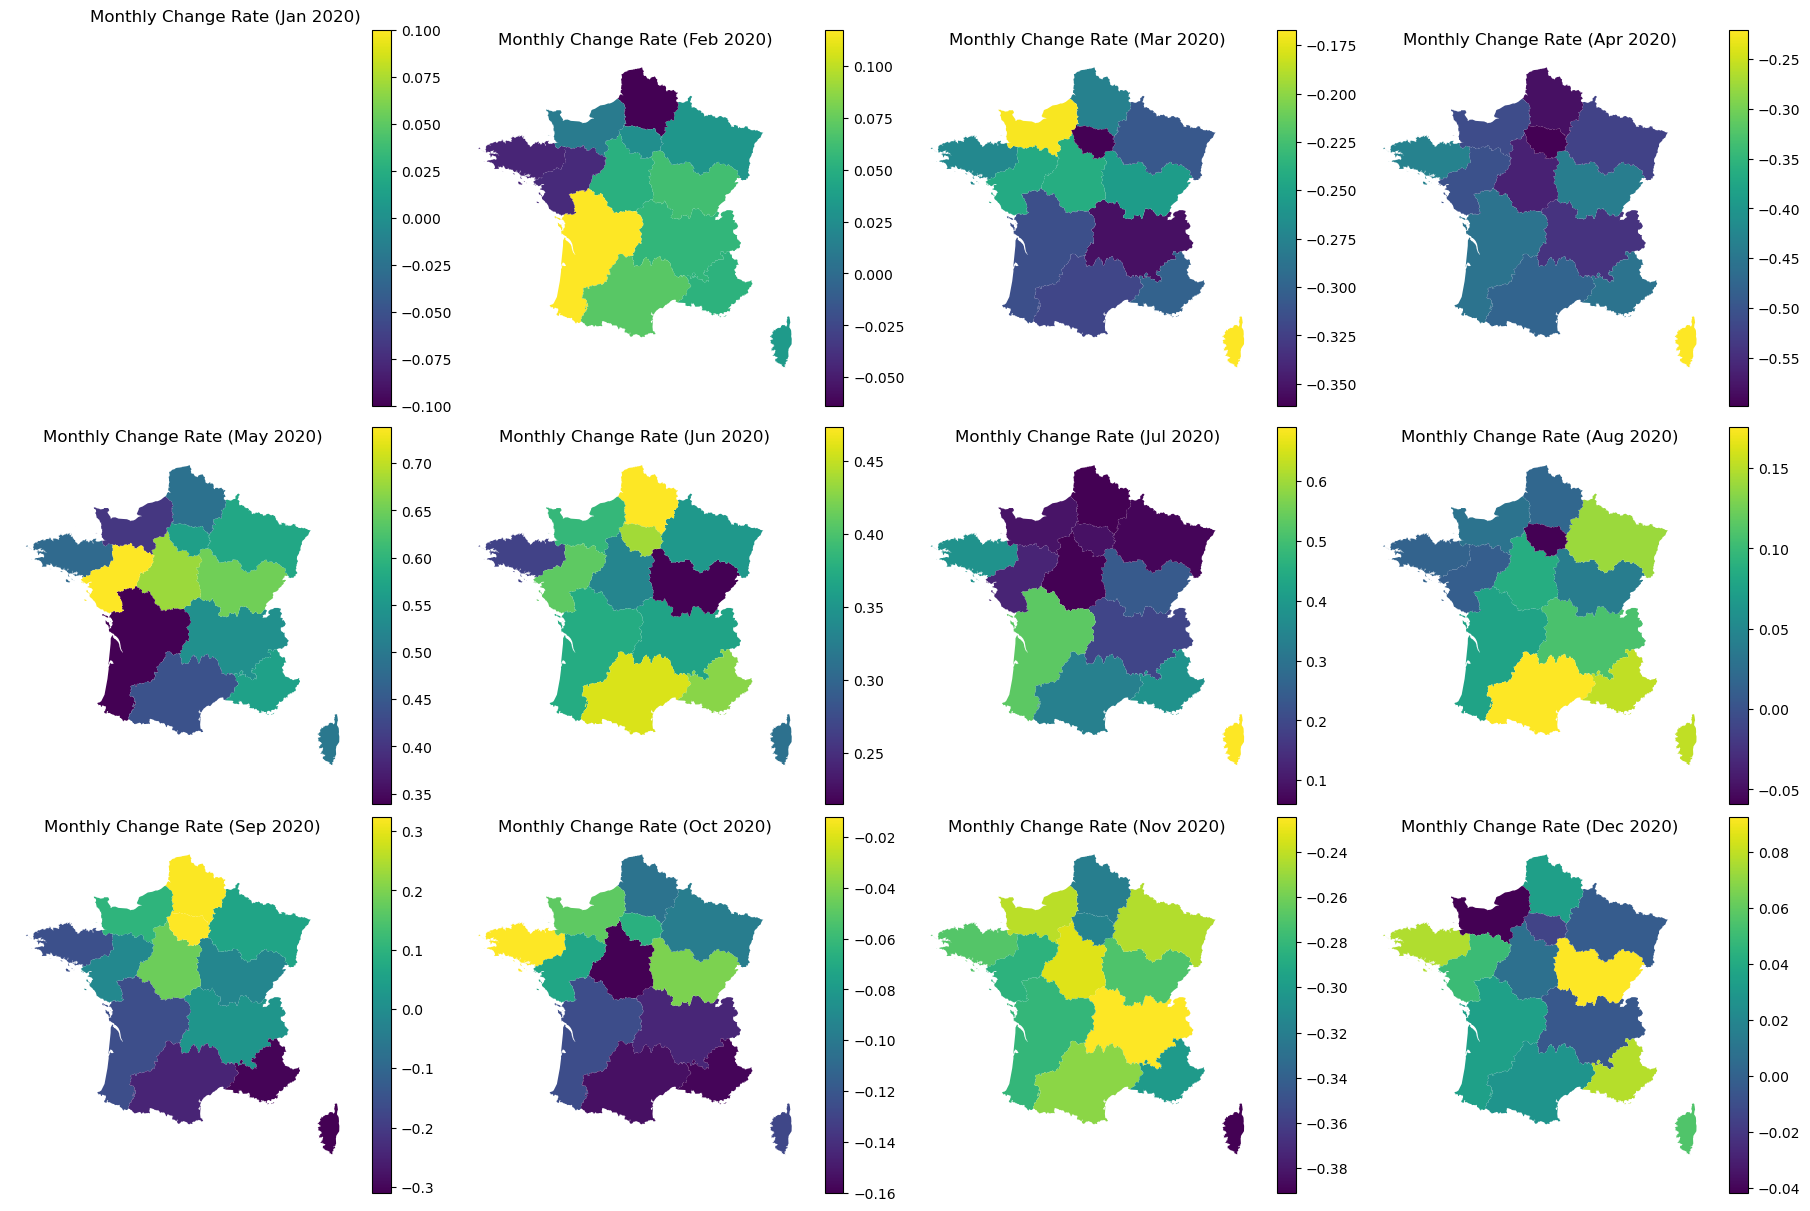

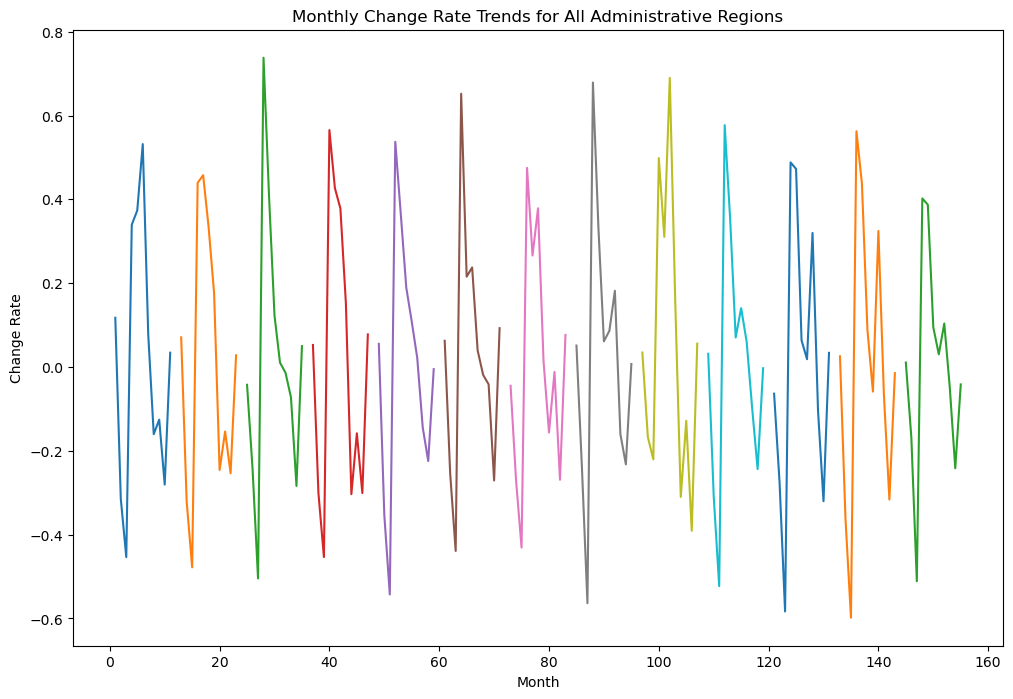



--------------- Done ---------------




<string>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.52it/s]


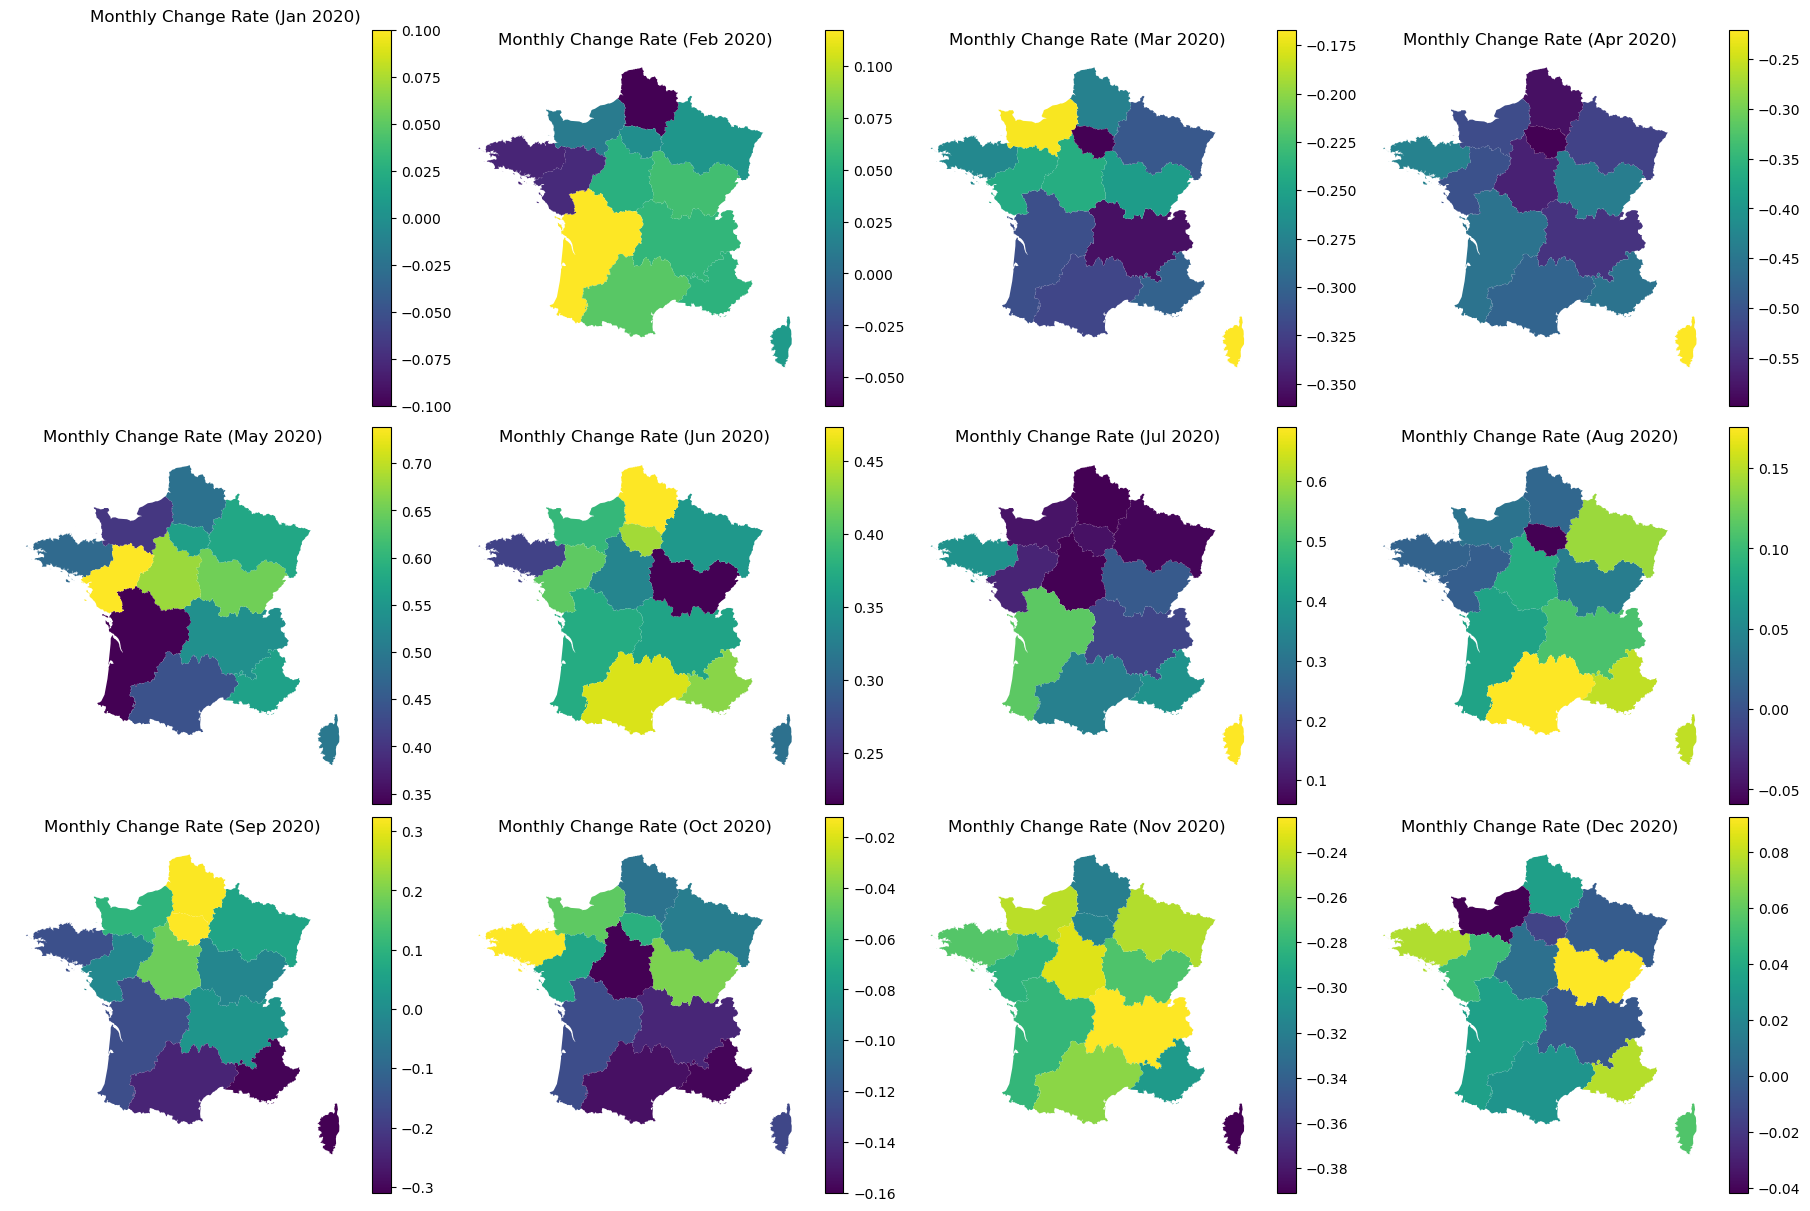

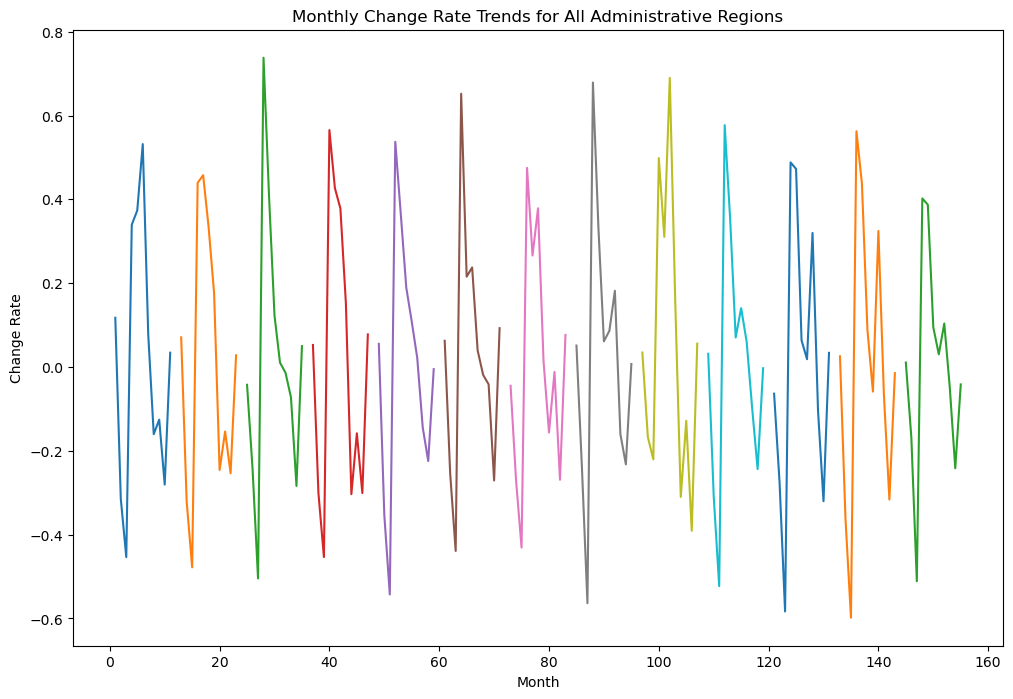



--------------- Done ---------------




<string>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.48it/s]


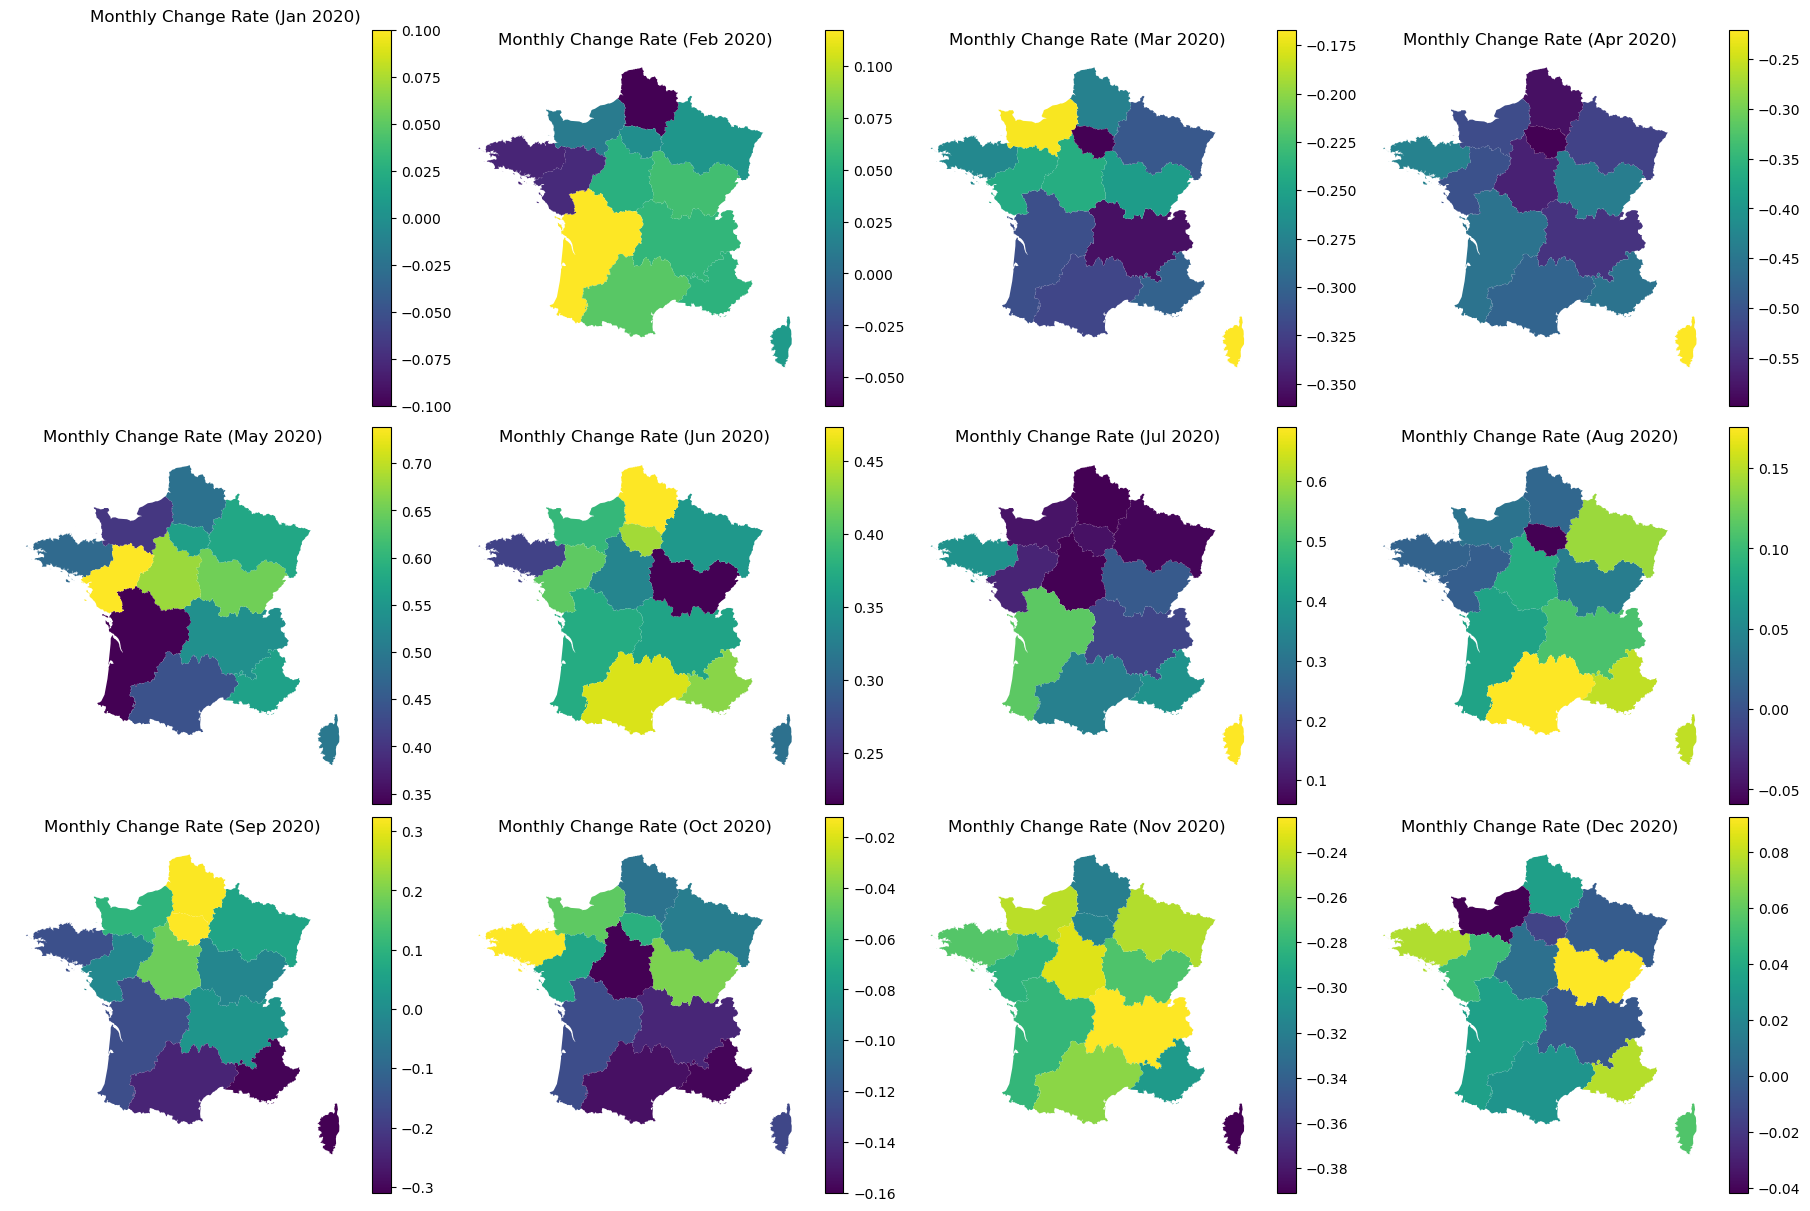

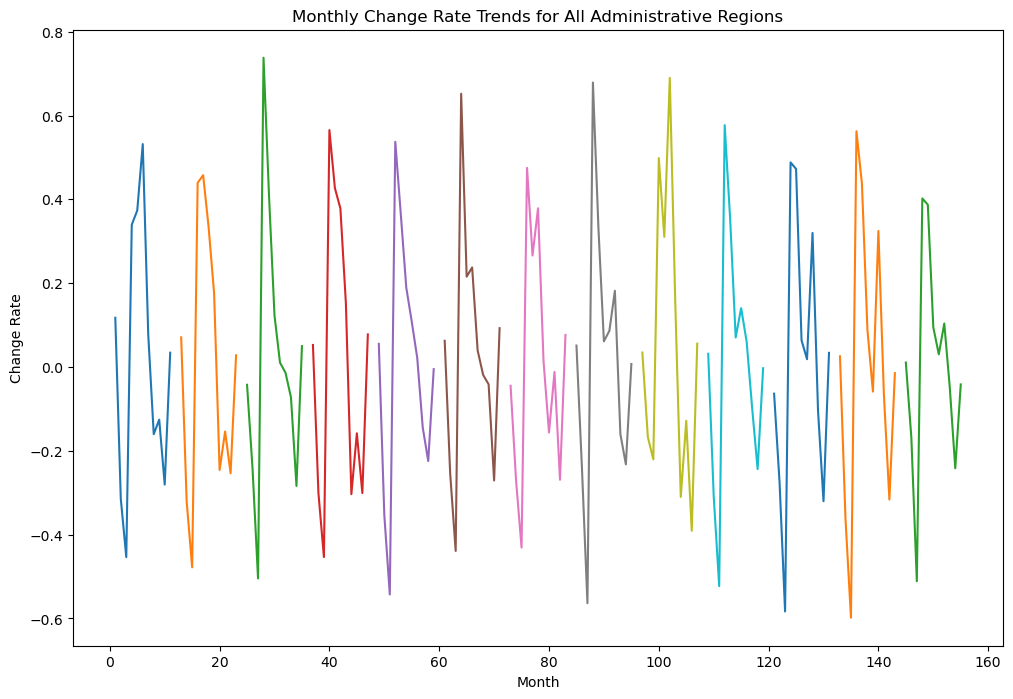



--------------- Done ---------------




<string>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt: 

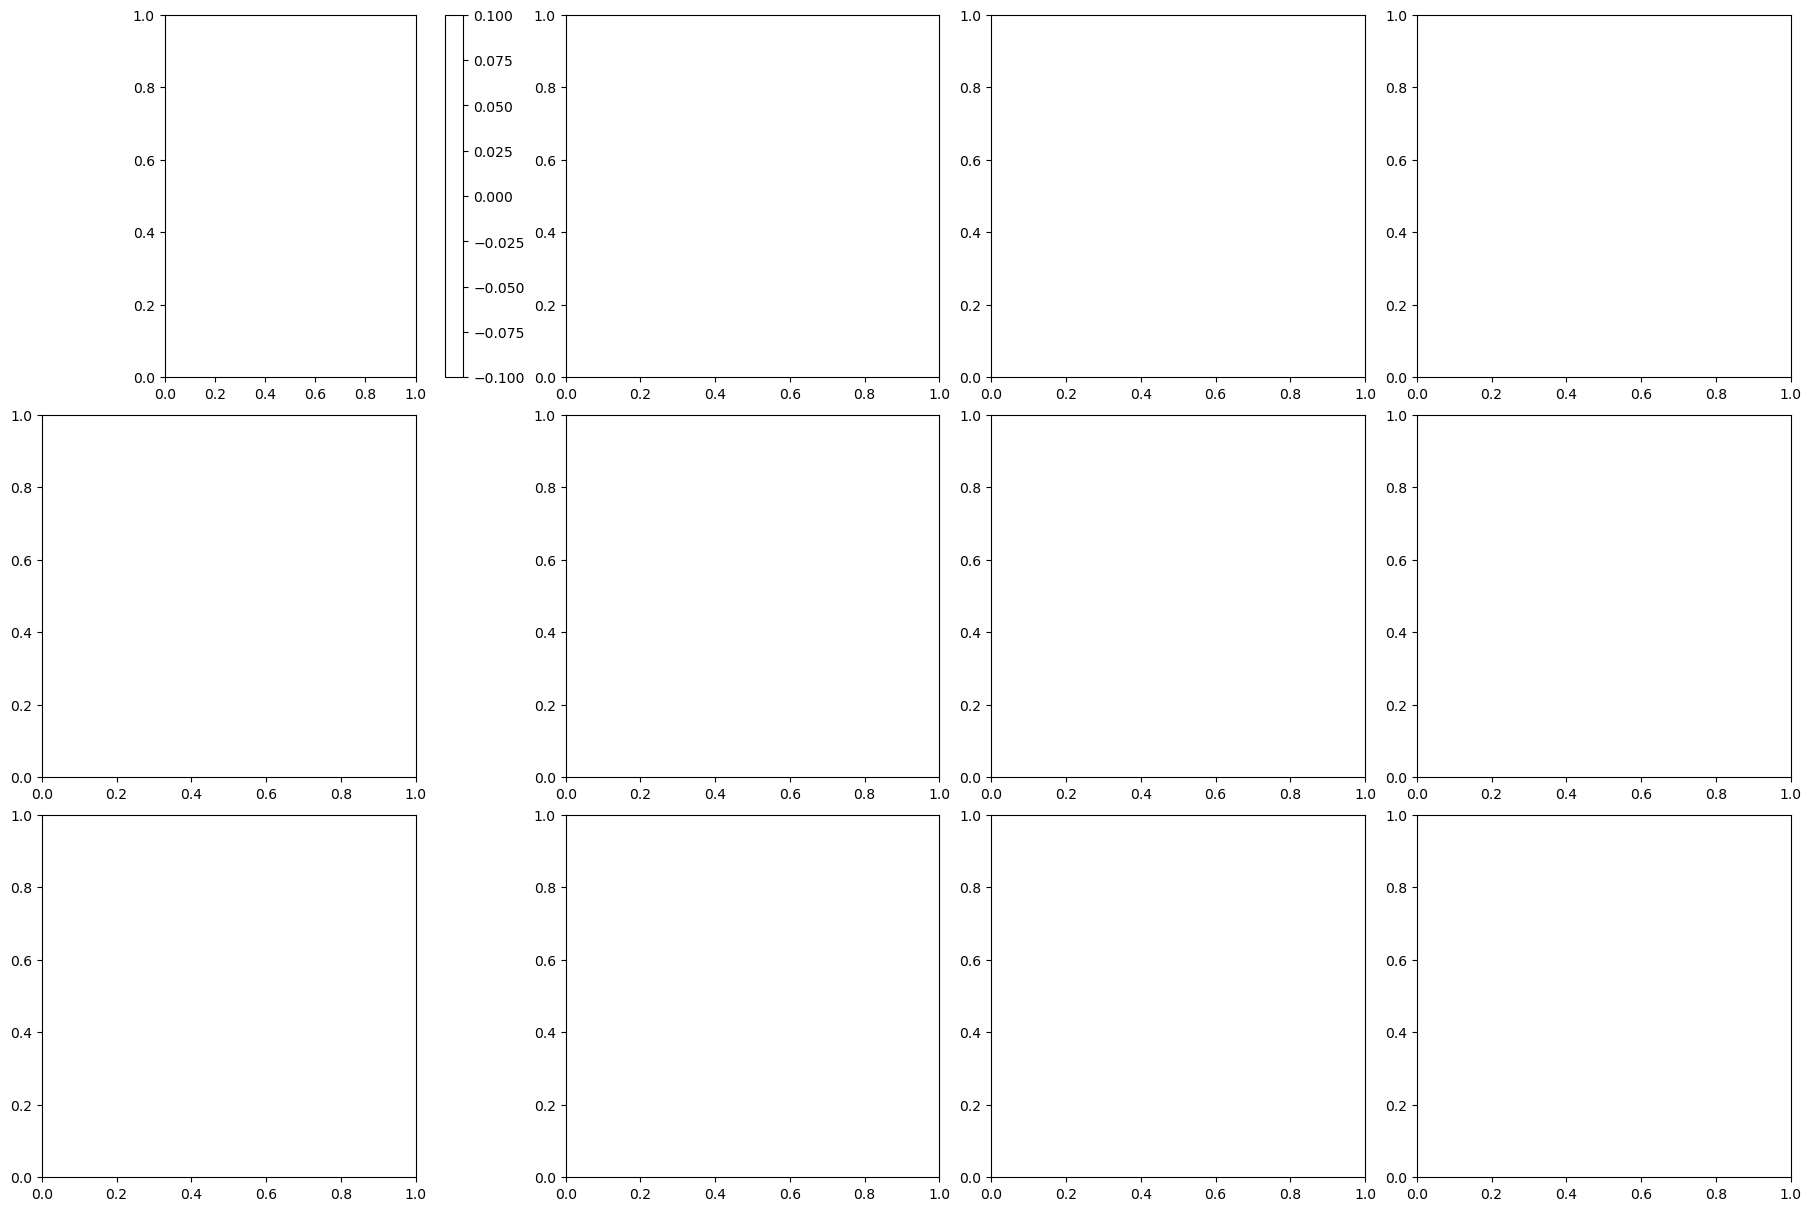

In [108]:
direct_request_LLM_response = solution.get_direct_request_LLM_response()

clear_output(wait=True)
display(Code(solution.direct_request_code, language='python'))

print("\n\n-------------- Running code --------------\n\n")

try_count = 0
try_limit = 10

while try_count < try_limit:

    try:
        exec(solution.direct_request_code)  # this will raise a ZeroDivisionError
        try_count += 1
    except Exception as e:
        print("An error occurred: ", e)

        debug_prompt = "You need to correct the code of a program, then return "


    print("\n\n--------------- Done ---------------\n\n")
